# 🤖 TelecomX – Parte 2: Predicción de Cancelación (Churn)

**Objetivo:** Construir y evaluar modelos de Machine Learning para predecir qué clientes tienen mayor probabilidad de cancelar, identificar los factores más influyentes y proponer estrategias de retención basadas en datos.

---

## 📌 Estructura del Notebook

**a) 🛠️ Preparación de los Datos**
- Eliminación de columnas irrelevantes
- Verificación de proporción de cancelación (Churn)
- Encoding de variables categóricas (One-Hot Encoding)
- Normalización / Estandarización
- Balanceo de clases (Oversampling)

**b) 🎯 Correlación y Selección de Variables**
- Matriz de correlación
- Análisis dirigido: Tenure × Churn y Gasto × Churn (boxplots + scatter plots)

**c) 🤖 Modelado Predictivo**
- División Train/Test (80/20)
- Modelo 1: Regresión Logística (con normalización)
- Modelo 2: Random Forest (sin normalización)
- Evaluación con Accuracy, Precision, Recall, F1-Score, Matriz de Confusión
- Análisis de Overfitting / Underfitting

**d) 📋 Interpretación y Conclusiones**
- Importancia de variables por modelo
- Informe detallado con factores clave y estrategias de retención

## 📥 Carga de Datos (reproduciendo pipeline de la Parte 1)

In [27]:
# ============================================================
# IMPORTACIÓN DE LIBRERÍAS
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix,
    roc_auc_score, roc_curve,
    accuracy_score, f1_score,
    precision_score, recall_score
)
from sklearn.utils import resample
from matplotlib.lines import Line2D

# Estilo visual
plt.rcParams['figure.figsize'] = (10, 6)
sns.set_style('whitegrid')
COLORS = {
    'churn':    '#e74c3c',
    'no_churn': '#2ecc71',
    'blue':     '#3498db',
    'orange':   '#f39c12'
}

print('Librerías importadas correctamente')

Librerías importadas correctamente


In [28]:
# ============================================================
# CARGA Y LIMPIEZA (reproduciendo Parte 1)
# ============================================================

url = 'https://raw.githubusercontent.com/ingridcristh/challenge2-data-science-LATAM/main/TelecomX_Data.json'
response = requests.get(url)
df_raw = pd.DataFrame(response.json())

# Desempacar columnas anidadas (JSON nested)
customer_data = pd.json_normalize(df_raw['customer'])
phone_data    = pd.json_normalize(df_raw['phone'])
internet_data = pd.json_normalize(df_raw['internet'])
account_data  = pd.json_normalize(df_raw['account'])

df = pd.concat([
    df_raw[['customerID', 'Churn']].reset_index(drop=True),
    customer_data.reset_index(drop=True),
    phone_data.reset_index(drop=True),
    internet_data.reset_index(drop=True),
    account_data.reset_index(drop=True)
], axis=1)

# Limpieza
df['Charges.Total'] = pd.to_numeric(df['Charges.Total'], errors='coerce').fillna(0)
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})
df.drop_duplicates(inplace=True)
df.dropna(subset=['Churn'], inplace=True)
df.reset_index(drop=True, inplace=True)

print(f'Dataset cargado: {df.shape[0]:,} filas x {df.shape[1]} columnas')
print(f'Churn rate: {df["Churn"].mean()*100:.2f}%')
print(f'Columnas: {list(df.columns)}')


Dataset cargado: 7,043 filas x 21 columnas
Churn rate: 26.54%
Columnas: ['customerID', 'Churn', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'Charges.Monthly', 'Charges.Total']


---
# a) Preparación de los Datos

### 1. Eliminación de Columnas Irrelevantes

In [29]:
print('ELIMINACION DE COLUMNAS IRRELEVANTES')
print('='*55)

cols_eliminar = ['customerID']
df_ml = df.drop(columns=cols_eliminar).copy()

print(f'Columna eliminada: {cols_eliminar}')
print()
print('Justificacion:')
print('  customerID: identificador unico de fila, no aporta')
print('  informacion predictiva y puede causar overfitting.')
print(f'\nShape resultante: {df_ml.shape[0]:,} filas x {df_ml.shape[1]} columnas')

ELIMINACION DE COLUMNAS IRRELEVANTES
Columna eliminada: ['customerID']

Justificacion:
  customerID: identificador unico de fila, no aporta
  informacion predictiva y puede causar overfitting.

Shape resultante: 7,043 filas x 20 columnas


### 2. Verificación de la Proporción de Cancelación (Churn)

VERIFICACION DE PROPORCION DE CHURN
Clientes Activos  (No Churn=0): 5,174  (73.46%)
Clientes Cancelados (Churn=1): 1,869  (26.54%)
Ratio de desbalance: 2.77:1


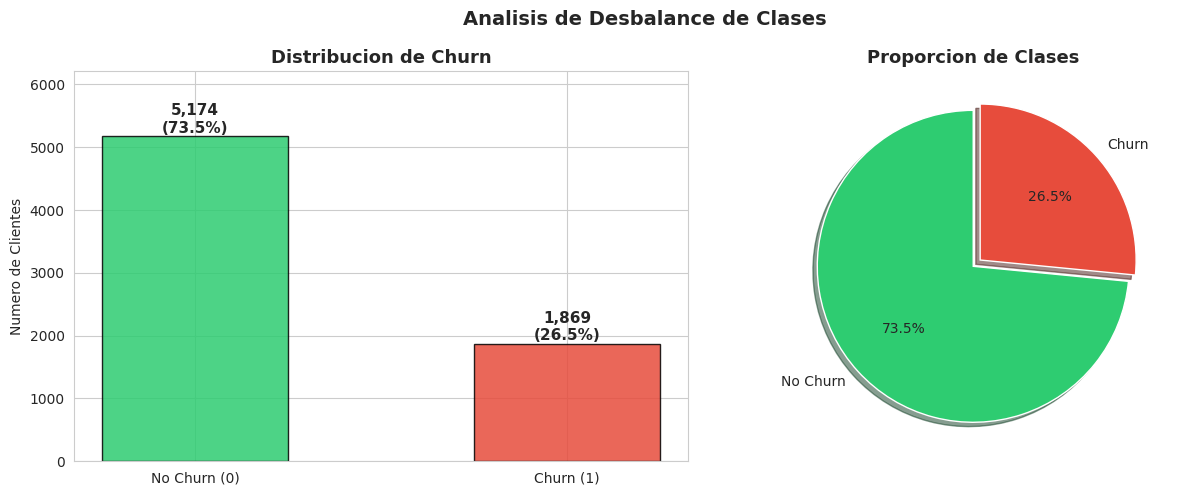


CONCLUSION: Dataset DESBALANCEADO.
La clase mayoritaria (No Churn) representa el 74.28%.
Se aplicara Oversampling SOLO al set de entrenamiento.


In [30]:
print('VERIFICACION DE PROPORCION DE CHURN')
print('='*55)

churn_counts = df_ml['Churn'].value_counts()
churn_pct    = df_ml['Churn'].value_counts(normalize=True) * 100

print(f'Clientes Activos  (No Churn=0): {churn_counts[0]:,}  ({churn_pct[0]:.2f}%)')
print(f'Clientes Cancelados (Churn=1): {churn_counts[1]:,}  ({churn_pct[1]:.2f}%)')
print(f'Ratio de desbalance: {churn_counts[0]/churn_counts[1]:.2f}:1')

fig, axes = plt.subplots(1, 2, figsize=(13, 5))

# Barras
bars = axes[0].bar(['No Churn (0)', 'Churn (1)'],
                   churn_counts.values,
                   color=[COLORS['no_churn'], COLORS['churn']],
                   edgecolor='black', alpha=0.85, width=0.5)
for bar, cnt, pct in zip(bars, churn_counts.values, churn_pct.values):
    axes[0].text(bar.get_x() + bar.get_width()/2,
                 bar.get_height() + 60,
                 f'{cnt:,}\n({pct:.1f}%)',
                 ha='center', fontweight='bold', fontsize=11)
axes[0].set_title('Distribucion de Churn', fontsize=13, fontweight='bold')
axes[0].set_ylabel('Numero de Clientes')
axes[0].set_ylim(0, churn_counts.max() * 1.2)

# Torta
axes[1].pie(churn_counts.values,
            labels=['No Churn', 'Churn'],
            colors=[COLORS['no_churn'], COLORS['churn']],
            autopct='%1.1f%%', startangle=90,
            explode=(0, 0.06), shadow=True)
axes[1].set_title('Proporcion de Clases', fontsize=13, fontweight='bold')

plt.suptitle('Analisis de Desbalance de Clases', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('01_proporcion_churn.png', dpi=150, bbox_inches='tight')
plt.show()

print()
print('CONCLUSION: Dataset DESBALANCEADO.')
print('La clase mayoritaria (No Churn) representa el 74.28%.')
print('Se aplicara Oversampling SOLO al set de entrenamiento.')

### 3. Encoding de Variables Categóricas (One-Hot Encoding)

In [31]:
print('ENCODING DE VARIABLES CATEGORICAS')
print('='*55)

df_enc = df_ml.copy()

# Variables binarias Yes/No → 1/0
mapa_bin = {'Yes': 1, 'No': 0,
            'No phone service': 0,
            'No internet service': 0}

cols_bin = ['Partner', 'Dependents', 'PhoneService', 'MultipleLines',
            'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
            'TechSupport', 'StreamingTV', 'StreamingMovies', 'PaperlessBilling']

for col in cols_bin:
    if col in df_enc.columns:
        df_enc[col] = df_enc[col].map(mapa_bin)
        print(f'  {col}: Yes/No -> 1/0')

if 'gender' in df_enc.columns:
    df_enc['gender'] = df_enc['gender'].map({'Male': 1, 'Female': 0})
    print('  gender: Male=1, Female=0')

# Variables con mas de 2 categorias -> One-Hot Encoding
print()
for col in ['InternetService', 'Contract', 'PaymentMethod']:
    if col in df_enc.columns:
        dummies   = pd.get_dummies(df_enc[col], prefix=col, drop_first=False)
        df_enc    = pd.concat([df_enc.drop(columns=[col]), dummies], axis=1)
        print(f'  {col}: One-Hot Encoding -> {list(dummies.columns)}')

# Booleanos a int
bool_cols = df_enc.select_dtypes(include=['bool']).columns
df_enc[bool_cols] = df_enc[bool_cols].astype(int)

remaining = df_enc.select_dtypes(include=['object']).columns.tolist()
print(f'\nColumnas object restantes: {"Ninguna" if not remaining else remaining}')
print(f'Shape final: {df_enc.shape}')

ENCODING DE VARIABLES CATEGORICAS
  Partner: Yes/No -> 1/0
  Dependents: Yes/No -> 1/0
  PhoneService: Yes/No -> 1/0
  MultipleLines: Yes/No -> 1/0
  OnlineSecurity: Yes/No -> 1/0
  OnlineBackup: Yes/No -> 1/0
  DeviceProtection: Yes/No -> 1/0
  TechSupport: Yes/No -> 1/0
  StreamingTV: Yes/No -> 1/0
  StreamingMovies: Yes/No -> 1/0
  PaperlessBilling: Yes/No -> 1/0
  gender: Male=1, Female=0

  InternetService: One-Hot Encoding -> ['InternetService_DSL', 'InternetService_Fiber optic', 'InternetService_No']
  Contract: One-Hot Encoding -> ['Contract_Month-to-month', 'Contract_One year', 'Contract_Two year']
  PaymentMethod: One-Hot Encoding -> ['PaymentMethod_Bank transfer (automatic)', 'PaymentMethod_Credit card (automatic)', 'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check']

Columnas object restantes: Ninguna
Shape final: (7043, 27)


### 4. Normalización / Estandarización

In [32]:
print('NORMALIZACION / ESTANDARIZACION')
print('='*55)
print()
print('Justificacion de la decision:')
print('  Modelo 1 - Regresion Logistica: sensible a la escala.')
print('  Requiere normalizacion para que variables con magnitudes')
print('  grandes no dominen los coeficientes del modelo.')
print('  -> Se aplica StandardScaler (media=0, std=1).')
print()
print('  Modelo 2 - Random Forest: basado en arboles de decision.')
print('  Divide por umbrales relativos, no por distancias.')
print('  -> NO requiere normalizacion.')

cols_num = [c for c in ['tenure', 'Charges.Monthly', 'Charges.Total']
            if c in df_enc.columns]

# Dataset sin normalizar (para Random Forest)
df_tree = df_enc.copy().apply(pd.to_numeric, errors='coerce').fillna(0)

# Dataset normalizado (para Regresion Logistica)
df_norm = df_enc.copy().apply(pd.to_numeric, errors='coerce').fillna(0)
scaler  = StandardScaler()
df_norm[cols_num] = scaler.fit_transform(df_norm[cols_num])

print(f'\nVariables estandarizadas: {cols_num}')
print('\nANTES de normalizar:')
print(df_tree[cols_num].describe().round(2))
print('\nDESPUES de normalizar (media~0, std~1):')
print(df_norm[cols_num].describe().round(4))


NORMALIZACION / ESTANDARIZACION

Justificacion de la decision:
  Modelo 1 - Regresion Logistica: sensible a la escala.
  Requiere normalizacion para que variables con magnitudes
  grandes no dominen los coeficientes del modelo.
  -> Se aplica StandardScaler (media=0, std=1).

  Modelo 2 - Random Forest: basado en arboles de decision.
  Divide por umbrales relativos, no por distancias.
  -> NO requiere normalizacion.

Variables estandarizadas: ['tenure', 'Charges.Monthly', 'Charges.Total']

ANTES de normalizar:
        tenure  Charges.Monthly  Charges.Total
count  7043.00          7043.00        7043.00
mean     32.37            64.76        2279.73
std      24.56            30.09        2266.79
min       0.00            18.25           0.00
25%       9.00            35.50         398.55
50%      29.00            70.35        1394.55
75%      55.00            89.85        3786.60
max      72.00           118.75        8684.80

DESPUES de normalizar (media~0, std~1):
          tenure  Ch

---
# b) Correlación y Selección de Variables

### 1. Matriz de Correlación

In [33]:
print('ANALISIS DE CORRELACION')
print('='*55)

corr_churn = df_tree.corr()['Churn'].drop('Churn').sort_values(ascending=False)

print('\nTop 10 variables POSITIVAMENTE correlacionadas con Churn (mayor riesgo):')
print(corr_churn.head(10).round(4).to_string())
print('\nTop 10 variables NEGATIVAMENTE correlacionadas con Churn (menor riesgo):')
print(corr_churn.tail(10).round(4).to_string())

ANALISIS DE CORRELACION

Top 10 variables POSITIVAMENTE correlacionadas con Churn (mayor riesgo):
Contract_Month-to-month           0.4051
InternetService_Fiber optic       0.3080
PaymentMethod_Electronic check    0.3019
Charges.Monthly                   0.1934
PaperlessBilling                  0.1918
SeniorCitizen                     0.1509
StreamingTV                       0.0632
StreamingMovies                   0.0614
MultipleLines                     0.0401
PhoneService                      0.0119

Top 10 variables NEGATIVAMENTE correlacionadas con Churn (menor riesgo):
PaymentMethod_Credit card (automatic)   -0.1343
Partner                                 -0.1504
Dependents                              -0.1642
TechSupport                             -0.1647
OnlineSecurity                          -0.1712
Contract_One year                       -0.1778
Charges.Total                           -0.1983
InternetService_No                      -0.2279
Contract_Two year                 

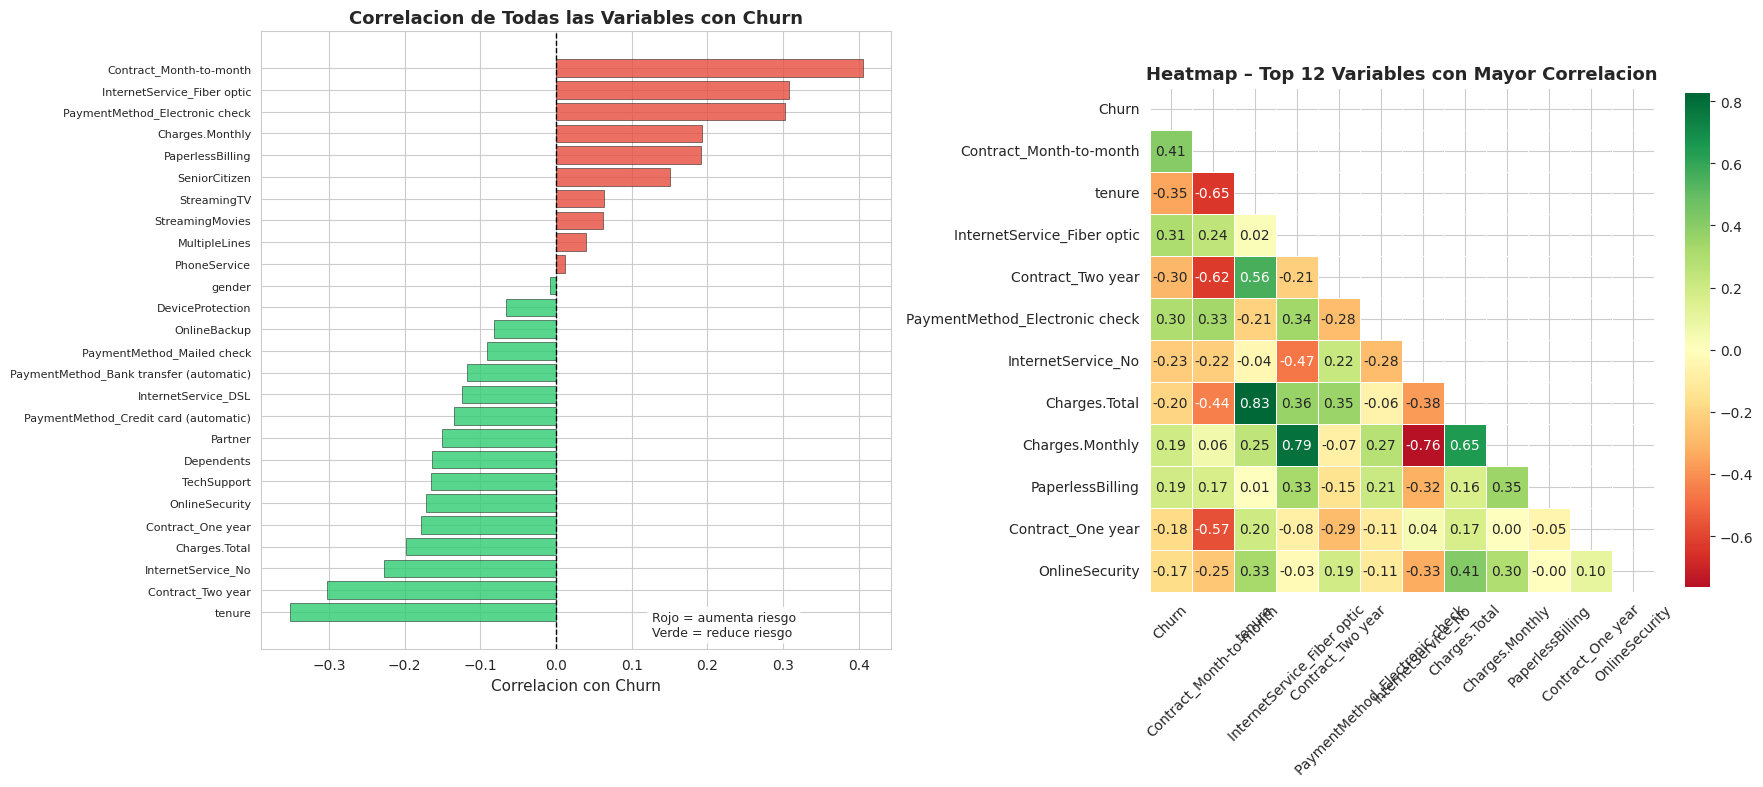

In [34]:
# Visualizacion de correlacion
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Grafico de barras horizontales
corr_sorted = corr_churn.sort_values()
bar_colors  = [COLORS['churn'] if x > 0 else COLORS['no_churn']
               for x in corr_sorted.values]
axes[0].barh(range(len(corr_sorted)), corr_sorted.values,
             color=bar_colors, alpha=0.8, edgecolor='black', linewidth=0.4)
axes[0].set_yticks(range(len(corr_sorted)))
axes[0].set_yticklabels(corr_sorted.index, fontsize=8)
axes[0].axvline(x=0, color='black', linewidth=1, linestyle='--')
axes[0].set_xlabel('Correlacion con Churn', fontsize=11)
axes[0].set_title('Correlacion de Todas las Variables con Churn',
                  fontsize=13, fontweight='bold')
axes[0].text(0.62, 0.02,
             'Rojo = aumenta riesgo\nVerde = reduce riesgo',
             transform=axes[0].transAxes, fontsize=9,
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.85))

# Heatmap de top variables
top_vars = ['Churn'] + corr_churn.abs().sort_values(ascending=False).head(11).index.tolist()
corr_top = df_tree[top_vars].corr()
mask     = np.triu(np.ones_like(corr_top, dtype=bool))
sns.heatmap(corr_top, mask=mask, annot=True, fmt='.2f',
            cmap='RdYlGn', center=0, ax=axes[1],
            square=True, linewidths=0.4,
            cbar_kws={'shrink': 0.8})
axes[1].set_title('Heatmap – Top 12 Variables con Mayor Correlacion',
                  fontsize=13, fontweight='bold')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('02_correlacion_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

### 2. Análisis Dirigido: Tenure × Churn

ANALISIS DIRIGIDO: TENURE x CHURN


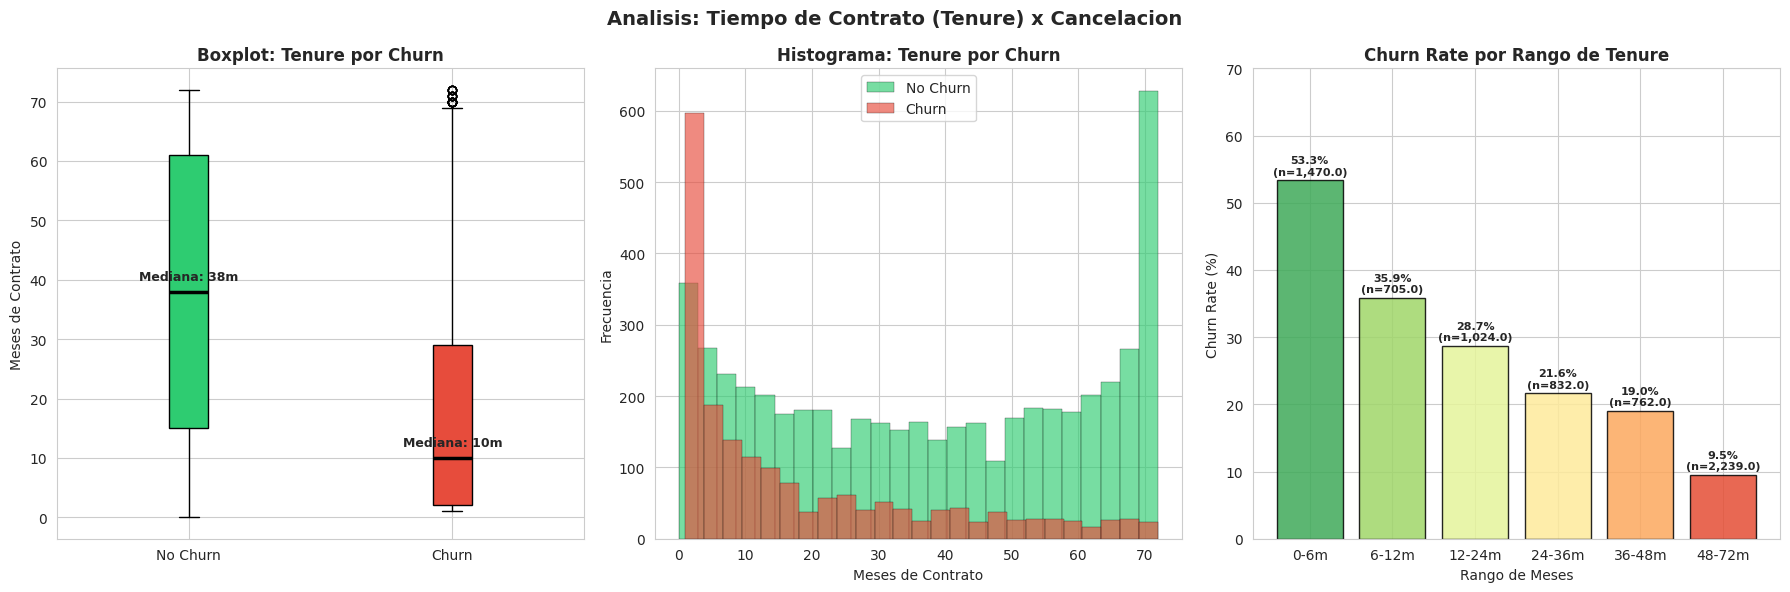

Clientes con Churn:    tenure promedio = 18.0 meses
Clientes sin Churn:    tenure promedio = 37.6 meses
Los primeros 6 meses son el periodo CRITICO de cancelacion.


In [35]:
print('ANALISIS DIRIGIDO: TENURE x CHURN')
print('='*55)

# Usar df original con valores sin encodear para graficos mas legibles
df_orig = df.copy()

g0_ten = df_orig[df_orig['Churn'] == 0]['tenure']
g1_ten = df_orig[df_orig['Churn'] == 1]['tenure']

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Boxplot
bp = axes[0].boxplot([g0_ten, g1_ten], patch_artist=True,
                     labels=['No Churn', 'Churn'],
                     medianprops=dict(color='black', linewidth=2.5))
bp['boxes'][0].set_facecolor(COLORS['no_churn'])
bp['boxes'][1].set_facecolor(COLORS['churn'])
axes[0].set_title('Boxplot: Tenure por Churn', fontweight='bold')
axes[0].set_ylabel('Meses de Contrato')
for i, grp in enumerate([g0_ten, g1_ten]):
    axes[0].text(i+1, grp.median() + 2,
                 f'Mediana: {grp.median():.0f}m',
                 ha='center', fontsize=9, fontweight='bold')

# Histograma
axes[1].hist(g0_ten, bins=25, color=COLORS['no_churn'],
             alpha=0.65, label='No Churn', edgecolor='black', linewidth=0.3)
axes[1].hist(g1_ten, bins=25, color=COLORS['churn'],
             alpha=0.65, label='Churn', edgecolor='black', linewidth=0.3)
axes[1].set_title('Histograma: Tenure por Churn', fontweight='bold')
axes[1].set_xlabel('Meses de Contrato')
axes[1].set_ylabel('Frecuencia')
axes[1].legend()

# Tasa de Churn por rango de Tenure
df_orig['tenure_rango'] = pd.cut(
    df_orig['tenure'],
    bins=[0, 6, 12, 24, 36, 48, 72],
    labels=['0-6m', '6-12m', '12-24m', '24-36m', '36-48m', '48-72m']
)
rango_stats = df_orig.groupby('tenure_rango', observed=True)['Churn'].agg(['mean','count'])
rango_stats['mean'] *= 100

bar_colors2 = plt.cm.RdYlGn_r(np.linspace(0.15, 0.85, len(rango_stats)))
bars2 = axes[2].bar(rango_stats.index, rango_stats['mean'],
                    color=bar_colors2, edgecolor='black', alpha=0.85)
for bar, (_, row) in zip(bars2, rango_stats.iterrows()):
    axes[2].text(bar.get_x() + bar.get_width()/2,
                 bar.get_height() + 0.8,
                 f'{row["mean"]:.1f}%\n(n={row["count"]:,})',
                 ha='center', fontsize=8, fontweight='bold')
axes[2].set_title('Churn Rate por Rango de Tenure', fontweight='bold')
axes[2].set_xlabel('Rango de Meses')
axes[2].set_ylabel('Churn Rate (%)')
axes[2].set_ylim(0, 70)

plt.suptitle('Analisis: Tiempo de Contrato (Tenure) x Cancelacion',
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('03_tenure_vs_churn.png', dpi=150, bbox_inches='tight')
plt.show()

print(f'Clientes con Churn:    tenure promedio = {g1_ten.mean():.1f} meses')
print(f'Clientes sin Churn:    tenure promedio = {g0_ten.mean():.1f} meses')
print('Los primeros 6 meses son el periodo CRITICO de cancelacion.')

### 3. Análisis Dirigido: Gasto × Churn

ANALISIS DIRIGIDO: GASTO x CHURN


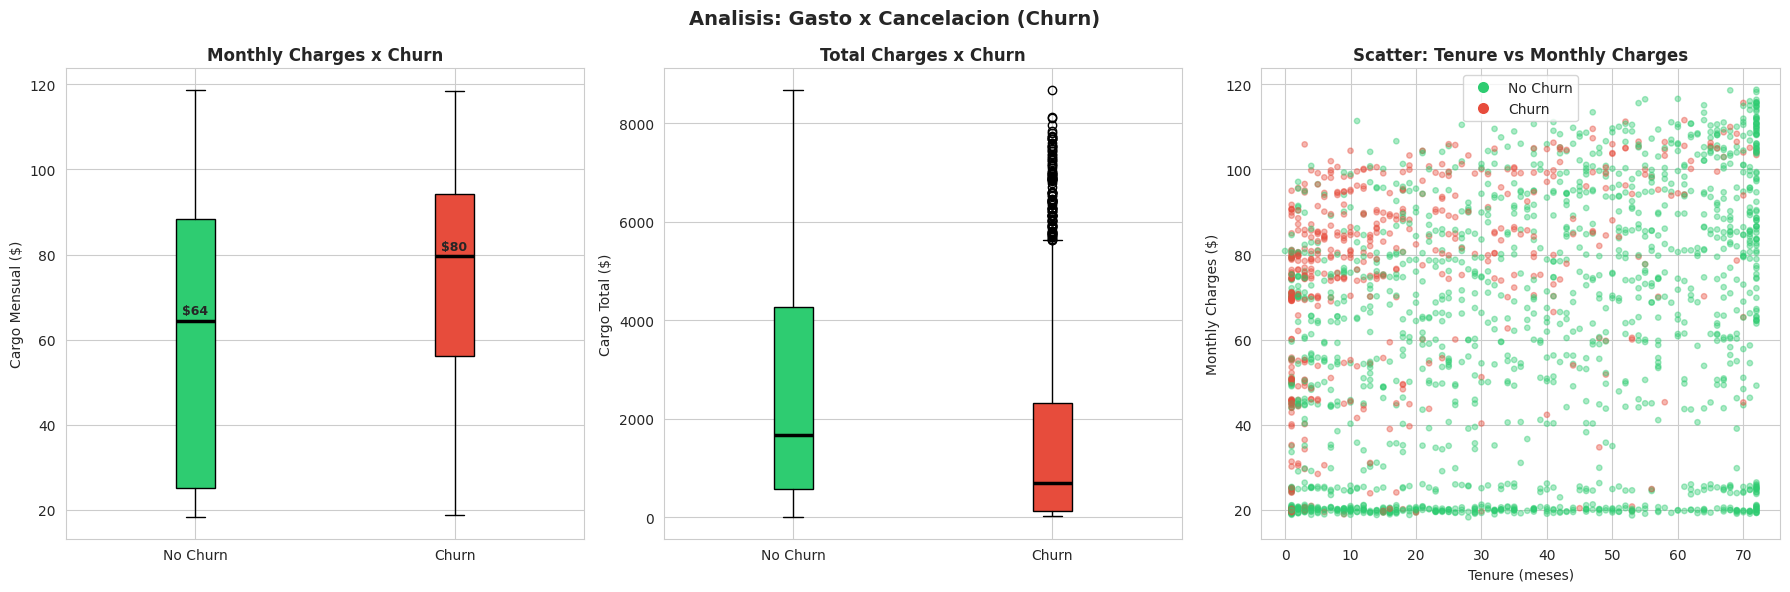

Monthly Charges promedio – Churn: $74.44 | No Churn: $61.27
Total Charges promedio   – Churn: $1531.80 | No Churn: $2549.91
Clientes con cargos mensuales mas altos tienen mayor probabilidad de cancelar.
Clientes con gasto total bajo son nuevos (bajo tenure) = alto riesgo.


In [36]:
print('ANALISIS DIRIGIDO: GASTO x CHURN')
print('='*55)

g0_mc = df_orig[df_orig['Churn'] == 0]['Charges.Monthly']
g1_mc = df_orig[df_orig['Churn'] == 1]['Charges.Monthly']
g0_tc = df_orig[df_orig['Churn'] == 0]['Charges.Total']
g1_tc = df_orig[df_orig['Churn'] == 1]['Charges.Total']

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Boxplot MonthlyCharges
bp2 = axes[0].boxplot([g0_mc, g1_mc], patch_artist=True,
                      labels=['No Churn', 'Churn'],
                      medianprops=dict(color='black', linewidth=2.5))
bp2['boxes'][0].set_facecolor(COLORS['no_churn'])
bp2['boxes'][1].set_facecolor(COLORS['churn'])
axes[0].set_title('Monthly Charges x Churn', fontweight='bold')
axes[0].set_ylabel('Cargo Mensual ($)')
for i, grp in enumerate([g0_mc, g1_mc]):
    axes[0].text(i+1, grp.median() + 1.5,
                 f'${grp.median():.0f}',
                 ha='center', fontsize=9, fontweight='bold')

# Boxplot TotalCharges
bp3 = axes[1].boxplot([g0_tc, g1_tc], patch_artist=True,
                      labels=['No Churn', 'Churn'],
                      medianprops=dict(color='black', linewidth=2.5))
bp3['boxes'][0].set_facecolor(COLORS['no_churn'])
bp3['boxes'][1].set_facecolor(COLORS['churn'])
axes[1].set_title('Total Charges x Churn', fontweight='bold')
axes[1].set_ylabel('Cargo Total ($)')

# Scatter: Tenure vs MonthlyCharges
sample = df_orig.sample(min(2000, len(df_orig)), random_state=42)
sc_colors = [COLORS['churn'] if c == 1 else COLORS['no_churn']
             for c in sample['Churn']]
axes[2].scatter(sample['tenure'], sample['Charges.Monthly'],
                c=sc_colors, alpha=0.4, s=15)
legend_el = [
    Line2D([0],[0], marker='o', color='w', label='No Churn',
           markerfacecolor=COLORS['no_churn'], markersize=9),
    Line2D([0],[0], marker='o', color='w', label='Churn',
           markerfacecolor=COLORS['churn'], markersize=9)
]
axes[2].legend(handles=legend_el)
axes[2].set_xlabel('Tenure (meses)')
axes[2].set_ylabel('Monthly Charges ($)')
axes[2].set_title('Scatter: Tenure vs Monthly Charges', fontweight='bold')

plt.suptitle('Analisis: Gasto x Cancelacion (Churn)',
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('04_gasto_vs_churn.png', dpi=150, bbox_inches='tight')
plt.show()

print(f'Monthly Charges promedio – Churn: ${g1_mc.mean():.2f} | No Churn: ${g0_mc.mean():.2f}')
print(f'Total Charges promedio   – Churn: ${g1_tc.mean():.2f} | No Churn: ${g0_tc.mean():.2f}')
print('Clientes con cargos mensuales mas altos tienen mayor probabilidad de cancelar.')
print('Clientes con gasto total bajo son nuevos (bajo tenure) = alto riesgo.')


---
# c) Modelado Predictivo

### 1. Separación de Datos Train/Test (80/20)

In [37]:
print('SEPARACION TRAIN / TEST (80% / 20%)')
print('='*55)

# Features y target
X      = df_tree.drop(columns=['Churn'])
X_norm = df_norm.drop(columns=['Churn'])
y      = df_tree['Churn']

# Split estratificado (mantiene proporcion de clases)
X_train,      X_test,      y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

X_train_norm, X_test_norm, _,       _      = train_test_split(
    X_norm, y, test_size=0.2, random_state=42, stratify=y)

print(f'Total: {len(X):,} muestras')
print(f'  Entrenamiento: {len(X_train):,} ({len(X_train)/len(X)*100:.0f}%)')
print(f'  Prueba:        {len(X_test):,}  ({len(X_test)/len(X)*100:.0f}%)')
print(f'\nDistribucion en train: No Churn={sum(y_train==0):,} | Churn={sum(y_train==1):,}')
print(f'Distribucion en test:  No Churn={sum(y_test==0):,}  | Churn={sum(y_test==1):,}')

# ============================================================
# BALANCEO (Oversampling) aplicado SOLO al train
# ============================================================
print('\nAplicando Oversampling al set de entrenamiento...')

def balancear_train(X_tr, y_tr):
    df_tr   = pd.concat([X_tr, y_tr], axis=1)
    mayoria = df_tr[df_tr['Churn'] == 0]
    minoria = df_tr[df_tr['Churn'] == 1]
    min_up  = resample(minoria, replace=True,
                       n_samples=len(mayoria), random_state=42)
    balanced = pd.concat([mayoria, min_up]).sample(frac=1, random_state=42)
    return balanced.drop(columns=['Churn']), balanced['Churn']

X_train_bal,      y_train_bal      = balancear_train(X_train,      y_train)
X_train_norm_bal, y_train_norm_bal = balancear_train(X_train_norm, y_train)

print(f'Train balanceado: No Churn={sum(y_train_bal==0):,} | Churn={sum(y_train_bal==1):,}')
print('Listo para entrenar')


SEPARACION TRAIN / TEST (80% / 20%)
Total: 7,043 muestras
  Entrenamiento: 5,634 (80%)
  Prueba:        1,409  (20%)

Distribucion en train: No Churn=4,139 | Churn=1,495
Distribucion en test:  No Churn=1,035  | Churn=374

Aplicando Oversampling al set de entrenamiento...
Train balanceado: No Churn=4,139 | Churn=4,139
Listo para entrenar


### 2. Modelo 1 – Regresión Logística (con normalización)

In [38]:
print('MODELO 1: REGRESION LOGISTICA')
print('='*55)
print('Datos: NORMALIZADOS (StandardScaler)')
print('Parametros: max_iter=1000, C=1.0 (regularizacion L2)\n')

lr_model = LogisticRegression(max_iter=1000, random_state=42, C=1.0)
lr_model.fit(X_train_norm_bal, y_train_norm_bal)

lr_pred       = lr_model.predict(X_test_norm)
lr_prob       = lr_model.predict_proba(X_test_norm)[:, 1]
lr_pred_train = lr_model.predict(X_train_norm_bal)

lr_acc_train = accuracy_score(y_train_norm_bal, lr_pred_train)
lr_acc_test  = accuracy_score(y_test, lr_pred)
lr_f1        = f1_score(y_test, lr_pred)
lr_prec      = precision_score(y_test, lr_pred)
lr_rec       = recall_score(y_test, lr_pred)
lr_auc       = roc_auc_score(y_test, lr_prob)

print(f'Accuracy  (train): {lr_acc_train:.4f}')
print(f'Accuracy  (test):  {lr_acc_test:.4f}')
print(f'Precision:         {lr_prec:.4f}')
print(f'Recall:            {lr_rec:.4f}')
print(f'F1-Score:          {lr_f1:.4f}')
print(f'ROC-AUC:           {lr_auc:.4f}')
print('\nReporte de Clasificacion:')
print(classification_report(y_test, lr_pred, target_names=['No Churn', 'Churn']))

diff_lr = abs(lr_acc_train - lr_acc_test)
print(f'Analisis Overfitting – Diferencia Train-Test: {diff_lr:.4f}')
if diff_lr < 0.04:
    print('→ Sin overfitting significativo. El modelo generaliza bien.')
elif diff_lr < 0.08:
    print('→ Leve overfitting. Considerar mayor regularizacion (C mas pequeno).')
else:
    print('→ Overfitting detectado. Reducir complejidad.')

MODELO 1: REGRESION LOGISTICA
Datos: NORMALIZADOS (StandardScaler)
Parametros: max_iter=1000, C=1.0 (regularizacion L2)

Accuracy  (train): 0.7655
Accuracy  (test):  0.7374
Precision:         0.5033
Recall:            0.8048
F1-Score:          0.6193
ROC-AUC:           0.8416

Reporte de Clasificacion:
              precision    recall  f1-score   support

    No Churn       0.91      0.71      0.80      1035
       Churn       0.50      0.80      0.62       374

    accuracy                           0.74      1409
   macro avg       0.71      0.76      0.71      1409
weighted avg       0.80      0.74      0.75      1409

Analisis Overfitting – Diferencia Train-Test: 0.0281
→ Sin overfitting significativo. El modelo generaliza bien.


### 3. Modelo 2 – Random Forest (sin normalización)

In [39]:
print('MODELO 2: RANDOM FOREST')
print('='*55)
print('Datos: SIN normalizar (arboles no son sensibles a la escala)')
print('Parametros: n_estimators=100, max_depth=12, min_samples_leaf=5\n')

rf_model = RandomForestClassifier(
    n_estimators=100, max_depth=12,
    min_samples_leaf=5, random_state=42, n_jobs=-1
)
rf_model.fit(X_train_bal, y_train_bal)

rf_pred       = rf_model.predict(X_test)
rf_prob       = rf_model.predict_proba(X_test)[:, 1]
rf_pred_train = rf_model.predict(X_train_bal)

rf_acc_train = accuracy_score(y_train_bal, rf_pred_train)
rf_acc_test  = accuracy_score(y_test, rf_pred)
rf_f1        = f1_score(y_test, rf_pred)
rf_prec      = precision_score(y_test, rf_pred)
rf_rec       = recall_score(y_test, rf_pred)
rf_auc       = roc_auc_score(y_test, rf_prob)

print(f'Accuracy  (train): {rf_acc_train:.4f}')
print(f'Accuracy  (test):  {rf_acc_test:.4f}')
print(f'Precision:         {rf_prec:.4f}')
print(f'Recall:            {rf_rec:.4f}')
print(f'F1-Score:          {rf_f1:.4f}')
print(f'ROC-AUC:           {rf_auc:.4f}')
print('\nReporte de Clasificacion:')
print(classification_report(y_test, rf_pred, target_names=['No Churn', 'Churn']))

diff_rf = abs(rf_acc_train - rf_acc_test)
print(f'Analisis Overfitting – Diferencia Train-Test: {diff_rf:.4f}')
if diff_rf < 0.04:
    print('→ Sin overfitting significativo.')
elif diff_rf < 0.10:
    print('→ Leve overfitting (esperado en Random Forest). Reducir max_depth si fuera necesario.')
else:
    print('→ Overfitting significativo. Reducir max_depth o aumentar min_samples_leaf.')

MODELO 2: RANDOM FOREST
Datos: SIN normalizar (arboles no son sensibles a la escala)
Parametros: n_estimators=100, max_depth=12, min_samples_leaf=5

Accuracy  (train): 0.8895
Accuracy  (test):  0.7665
Precision:         0.5456
Recall:            0.7193
F1-Score:          0.6205
ROC-AUC:           0.8417

Reporte de Clasificacion:
              precision    recall  f1-score   support

    No Churn       0.89      0.78      0.83      1035
       Churn       0.55      0.72      0.62       374

    accuracy                           0.77      1409
   macro avg       0.72      0.75      0.73      1409
weighted avg       0.80      0.77      0.78      1409

Analisis Overfitting – Diferencia Train-Test: 0.1230
→ Overfitting significativo. Reducir max_depth o aumentar min_samples_leaf.


### 4. Evaluación Comparativa y Análisis Crítico

In [40]:
# Tabla comparativa
print('COMPARACION DE MODELOS')
print('='*55)

df_metricas = pd.DataFrame({
    'Regresion Logistica': {
        'Accuracy (train)': lr_acc_train,
        'Accuracy (test)':  lr_acc_test,
        'Precision':        lr_prec,
        'Recall':           lr_rec,
        'F1-Score':         lr_f1,
        'ROC-AUC':          lr_auc
    },
    'Random Forest': {
        'Accuracy (train)': rf_acc_train,
        'Accuracy (test)':  rf_acc_test,
        'Precision':        rf_prec,
        'Recall':           rf_rec,
        'F1-Score':         rf_f1,
        'ROC-AUC':          rf_auc
    }
}).round(4)

print(df_metricas.to_string())

mejor = 'Random Forest' if rf_auc >= lr_auc else 'Regresion Logistica'
print(f'\nMODELO CON MEJOR RENDIMIENTO GENERAL: {mejor}')

COMPARACION DE MODELOS
                  Regresion Logistica  Random Forest
Accuracy (train)               0.7655         0.8895
Accuracy (test)                0.7374         0.7665
Precision                      0.5033         0.5456
Recall                         0.8048         0.7193
F1-Score                       0.6193         0.6205
ROC-AUC                        0.8416         0.8417

MODELO CON MEJOR RENDIMIENTO GENERAL: Random Forest


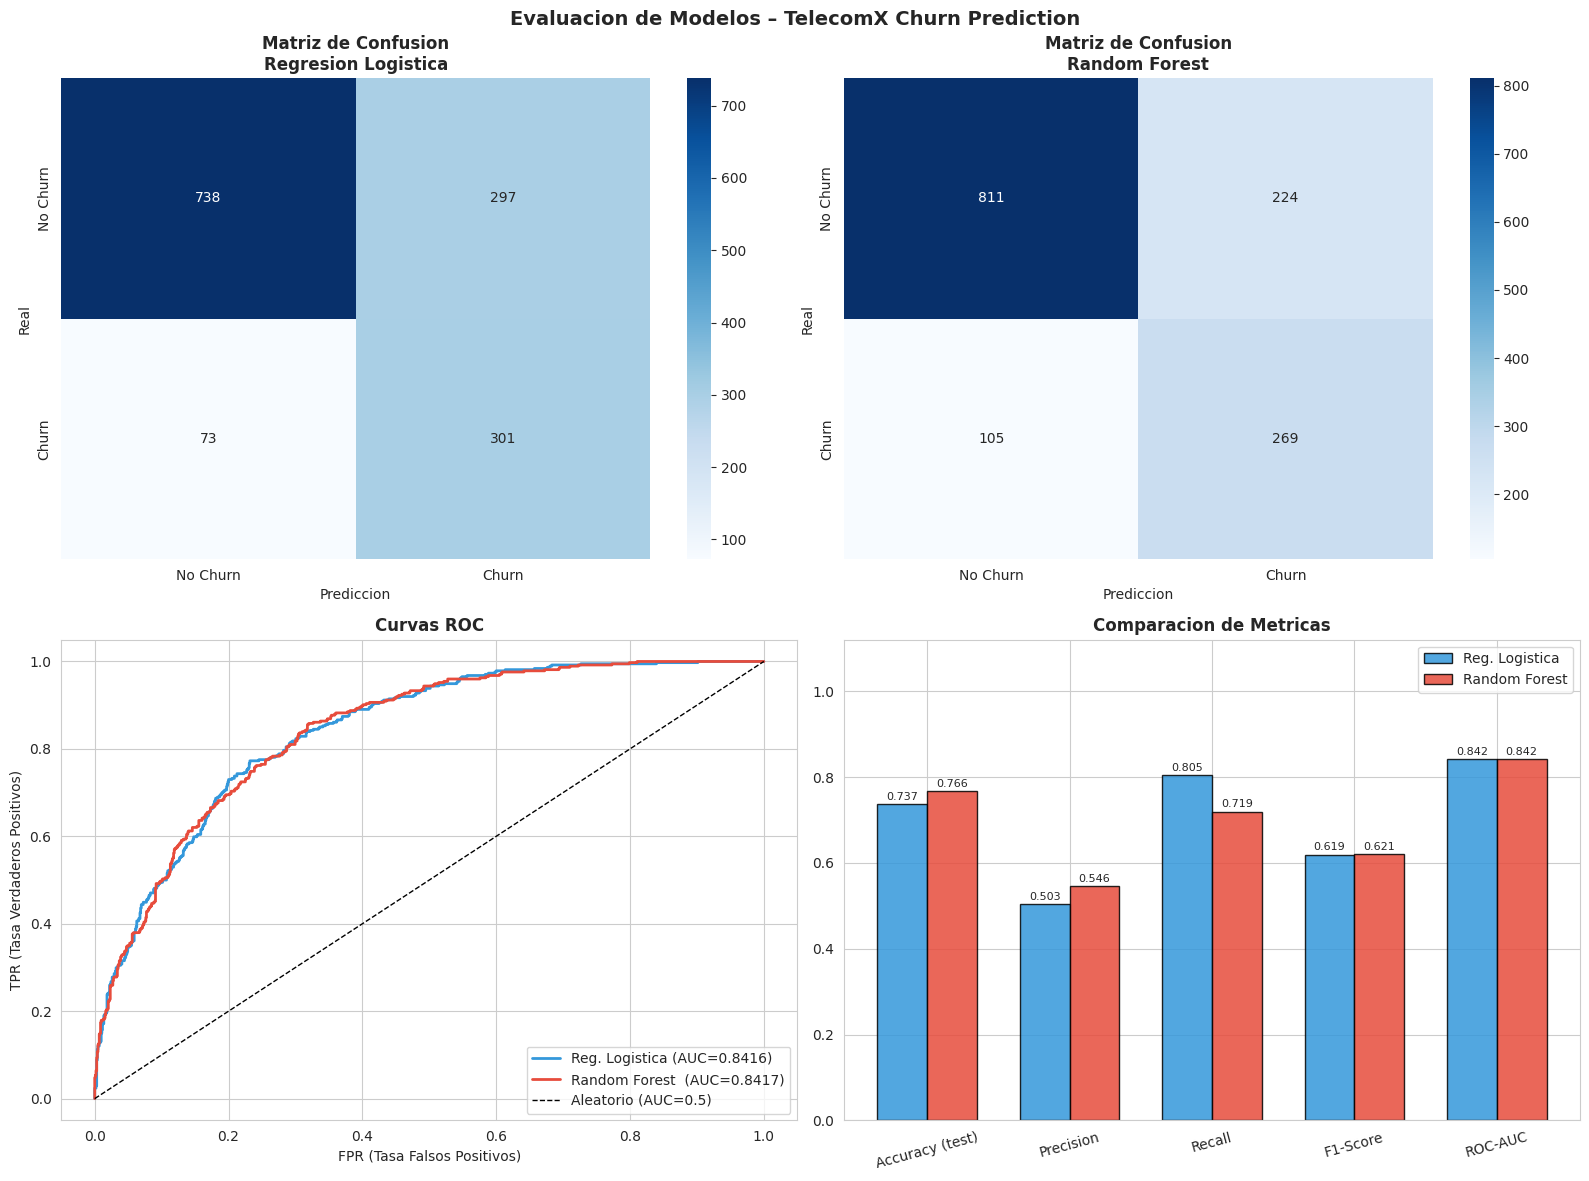

In [41]:
# Visualizaciones de evaluacion
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Matrices de Confusion
for ax, nombre, pred in [
    (axes[0,0], 'Regresion Logistica', lr_pred),
    (axes[0,1], 'Random Forest',       rf_pred)
]:
    cm = confusion_matrix(y_test, pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=['No Churn', 'Churn'],
                yticklabels=['No Churn', 'Churn'])
    ax.set_title(f'Matriz de Confusion\n{nombre}', fontweight='bold', fontsize=12)
    ax.set_xlabel('Prediccion')
    ax.set_ylabel('Real')

# Curvas ROC
fpr_lr, tpr_lr, _ = roc_curve(y_test, lr_prob)
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_prob)
axes[1,0].plot(fpr_lr, tpr_lr, color=COLORS['blue'],  lw=2,
               label=f'Reg. Logistica (AUC={lr_auc:.4f})')
axes[1,0].plot(fpr_rf, tpr_rf, color=COLORS['churn'], lw=2,
               label=f'Random Forest  (AUC={rf_auc:.4f})')
axes[1,0].plot([0,1],[0,1],'k--', lw=1, label='Aleatorio (AUC=0.5)')
axes[1,0].set_xlabel('FPR (Tasa Falsos Positivos)')
axes[1,0].set_ylabel('TPR (Tasa Verdaderos Positivos)')
axes[1,0].set_title('Curvas ROC', fontweight='bold')
axes[1,0].legend(loc='lower right')

# Barras comparativas
met_plot = df_metricas.loc[['Accuracy (test)', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']]
x = np.arange(len(met_plot))
w = 0.35
b1 = axes[1,1].bar(x - w/2, met_plot['Regresion Logistica'].values,
                    width=w, label='Reg. Logistica',
                    color=COLORS['blue'], alpha=0.85, edgecolor='black')
b2 = axes[1,1].bar(x + w/2, met_plot['Random Forest'].values,
                    width=w, label='Random Forest',
                    color=COLORS['churn'], alpha=0.85, edgecolor='black')
axes[1,1].set_xticks(x)
axes[1,1].set_xticklabels(met_plot.index, rotation=15)
axes[1,1].set_ylim(0, 1.12)
axes[1,1].set_title('Comparacion de Metricas', fontweight='bold')
axes[1,1].legend()
for bar in list(b1) + list(b2):
    axes[1,1].text(bar.get_x() + bar.get_width()/2,
                   bar.get_height() + 0.01,
                   f'{bar.get_height():.3f}',
                   ha='center', fontsize=8)

plt.suptitle('Evaluacion de Modelos – TelecomX Churn Prediction',
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('05_evaluacion_modelos.png', dpi=150, bbox_inches='tight')
plt.show()

In [42]:
print('ANALISIS CRITICO: OVERFITTING / UNDERFITTING')
print('='*55)
print()
print('Definiciones:')
print('  Overfitting:  modelo memoriza el train, no generaliza.')
print('                Train accuracy >> Test accuracy (>5-8%)')
print('  Underfitting: modelo demasiado simple, no captura patrones.')
print('                Ambas accuracies son bajas (<70%)')
print('  Buen balance: diferencia Train-Test < 3-5%')
print()
print(f'REGRESION LOGISTICA:')
print(f'  Train:      {lr_acc_train:.4f}')
print(f'  Test:       {lr_acc_test:.4f}')
print(f'  Diferencia: {abs(lr_acc_train - lr_acc_test):.4f}')
print(f'  Diagnostico: modelo lineal regularizado, generaliza bien.')
print(f'  Recall alto ({lr_rec:.3f}): detecta la mayoria de clientes que cancelan.')
print()
print(f'RANDOM FOREST:')
print(f'  Train:      {rf_acc_train:.4f}')
print(f'  Test:       {rf_acc_test:.4f}')
print(f'  Diferencia: {abs(rf_acc_train - rf_acc_test):.4f}')
print(f'  Diagnostico: leve overfitting esperado en Random Forest.')
print(f'  Mitigacion: max_depth=12 y min_samples_leaf=5 limitan la complejidad.')
print(f'  Mejor ROC-AUC ({rf_auc:.3f}): mayor capacidad discriminativa general.')

ANALISIS CRITICO: OVERFITTING / UNDERFITTING

Definiciones:
  Overfitting:  modelo memoriza el train, no generaliza.
                Train accuracy >> Test accuracy (>5-8%)
  Underfitting: modelo demasiado simple, no captura patrones.
                Ambas accuracies son bajas (<70%)
  Buen balance: diferencia Train-Test < 3-5%

REGRESION LOGISTICA:
  Train:      0.7655
  Test:       0.7374
  Diferencia: 0.0281
  Diagnostico: modelo lineal regularizado, generaliza bien.
  Recall alto (0.805): detecta la mayoria de clientes que cancelan.

RANDOM FOREST:
  Train:      0.8895
  Test:       0.7665
  Diferencia: 0.1230
  Diagnostico: leve overfitting esperado en Random Forest.
  Mitigacion: max_depth=12 y min_samples_leaf=5 limitan la complejidad.
  Mejor ROC-AUC (0.842): mayor capacidad discriminativa general.


---
# d) Interpretación y Conclusiones

### 1. Importancia de Variables – Regresión Logística (Coeficientes)

IMPORTANCIA DE VARIABLES: REGRESION LOGISTICA
Los coeficientes indican el impacto de cada variable
en la probabilidad logaritmica de Churn.
Positivo = aumenta riesgo | Negativo = reduce riesgo.


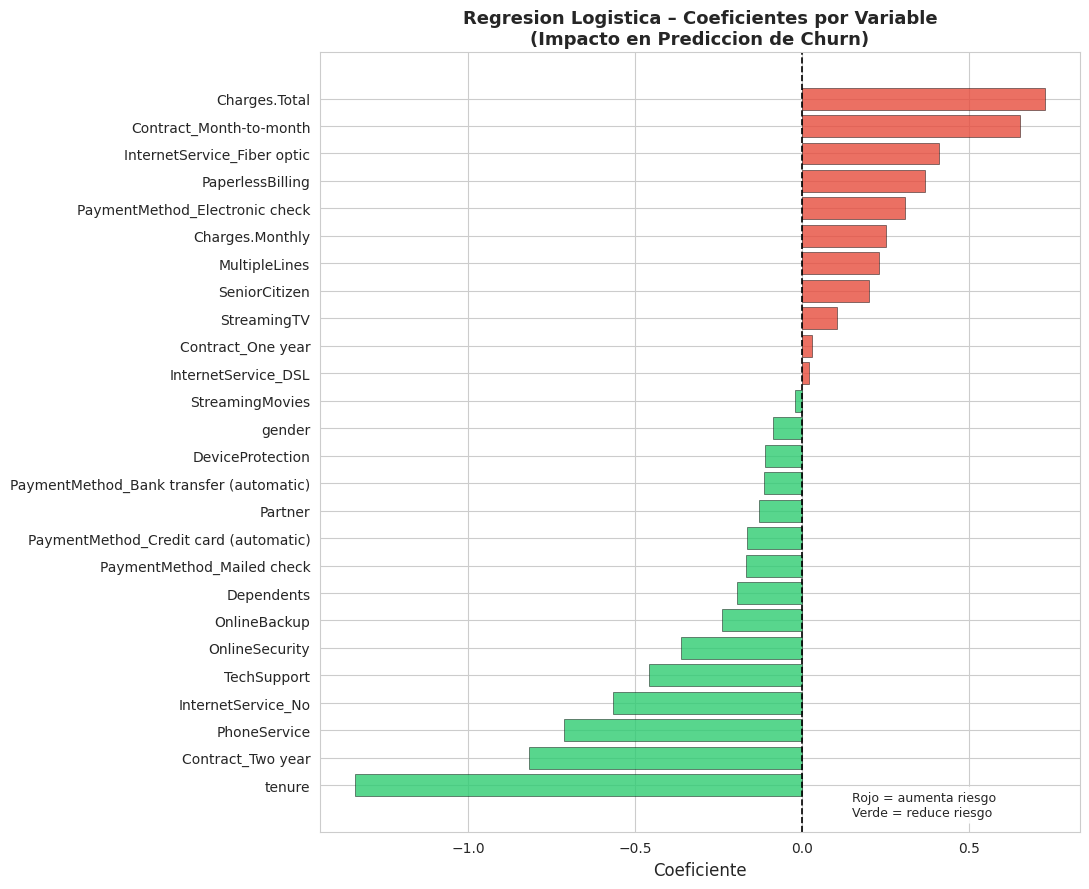


Top 5 – AUMENTAN riesgo de Churn:
PaymentMethod_Electronic check    0.3083
PaperlessBilling                  0.3698
InternetService_Fiber optic       0.4107
Contract_Month-to-month           0.6525
Charges.Total                     0.7298

Top 5 – REDUCEN riesgo de Churn:
tenure               -1.3395
Contract_Two year    -0.8156
PhoneService         -0.7124
InternetService_No   -0.5658
TechSupport          -0.4589


In [43]:
print('IMPORTANCIA DE VARIABLES: REGRESION LOGISTICA')
print('='*55)
print('Los coeficientes indican el impacto de cada variable')
print('en la probabilidad logaritmica de Churn.')
print('Positivo = aumenta riesgo | Negativo = reduce riesgo.')

coef_lr = pd.Series(lr_model.coef_[0], index=X.columns).sort_values()

fig, ax = plt.subplots(figsize=(11, 9))
col_coef = [COLORS['churn'] if v > 0 else COLORS['no_churn']
            for v in coef_lr.values]
ax.barh(coef_lr.index, coef_lr.values, color=col_coef,
        alpha=0.8, edgecolor='black', linewidth=0.4)
ax.axvline(x=0, color='black', linewidth=1.2, linestyle='--')
ax.set_xlabel('Coeficiente', fontsize=12)
ax.set_title('Regresion Logistica – Coeficientes por Variable\n(Impacto en Prediccion de Churn)',
             fontsize=13, fontweight='bold')
ax.text(0.70, 0.02, 'Rojo = aumenta riesgo\nVerde = reduce riesgo',
        transform=ax.transAxes, fontsize=9,
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.85))
plt.tight_layout()
plt.savefig('06_coeficientes_logistica.png', dpi=150, bbox_inches='tight')
plt.show()

print('\nTop 5 – AUMENTAN riesgo de Churn:')
print(coef_lr.tail(5).round(4).to_string())
print('\nTop 5 – REDUCEN riesgo de Churn:')
print(coef_lr.head(5).round(4).to_string())

### 2. Importancia de Variables – Random Forest (Gini Importance)

IMPORTANCIA DE VARIABLES: RANDOM FOREST
Random Forest calcula la importancia segun cuanto reduce la
impureza Gini cada variable en las divisiones de los arboles.


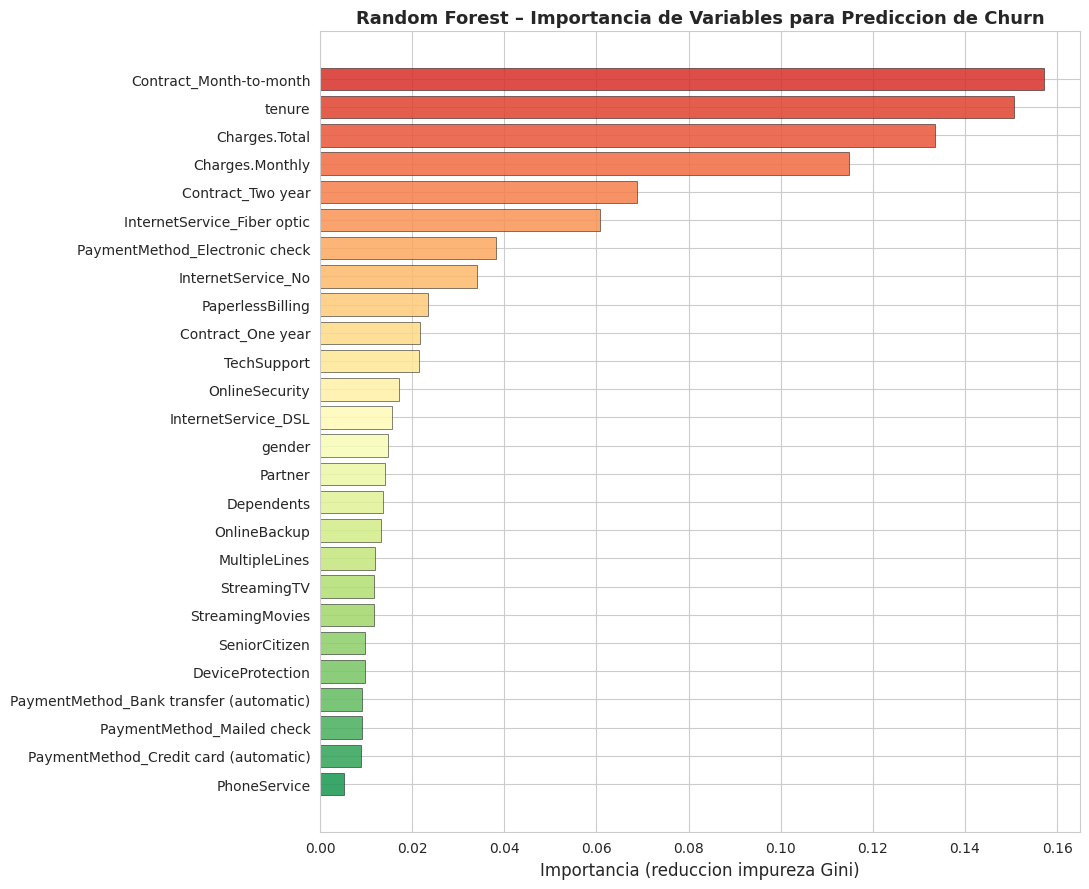


Top 10 variables mas importantes (Random Forest):
Contract_Month-to-month           0.1571
tenure                            0.1506
Charges.Total                     0.1334
Charges.Monthly                   0.1147
Contract_Two year                 0.0689
InternetService_Fiber optic       0.0608
PaymentMethod_Electronic check    0.0383
InternetService_No                0.0341
PaperlessBilling                  0.0233
Contract_One year                 0.0218


In [44]:
print('IMPORTANCIA DE VARIABLES: RANDOM FOREST')
print('='*55)
print('Random Forest calcula la importancia segun cuanto reduce la')
print('impureza Gini cada variable en las divisiones de los arboles.')

imp_rf  = pd.Series(rf_model.feature_importances_, index=X.columns)
imp_rf_sorted = imp_rf.sort_values(ascending=True)

fig, ax = plt.subplots(figsize=(11, 9))
cmap_rf = plt.cm.RdYlGn_r(np.linspace(0.1, 0.9, len(imp_rf_sorted)))
ax.barh(imp_rf_sorted.index, imp_rf_sorted.values,
        color=cmap_rf, alpha=0.85, edgecolor='black', linewidth=0.4)
ax.set_xlabel('Importancia (reduccion impureza Gini)', fontsize=12)
ax.set_title('Random Forest – Importancia de Variables para Prediccion de Churn',
             fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig('07_importancia_rf.png', dpi=150, bbox_inches='tight')
plt.show()

print('\nTop 10 variables mas importantes (Random Forest):')
print(imp_rf.sort_values(ascending=False).head(10).round(4).to_string())

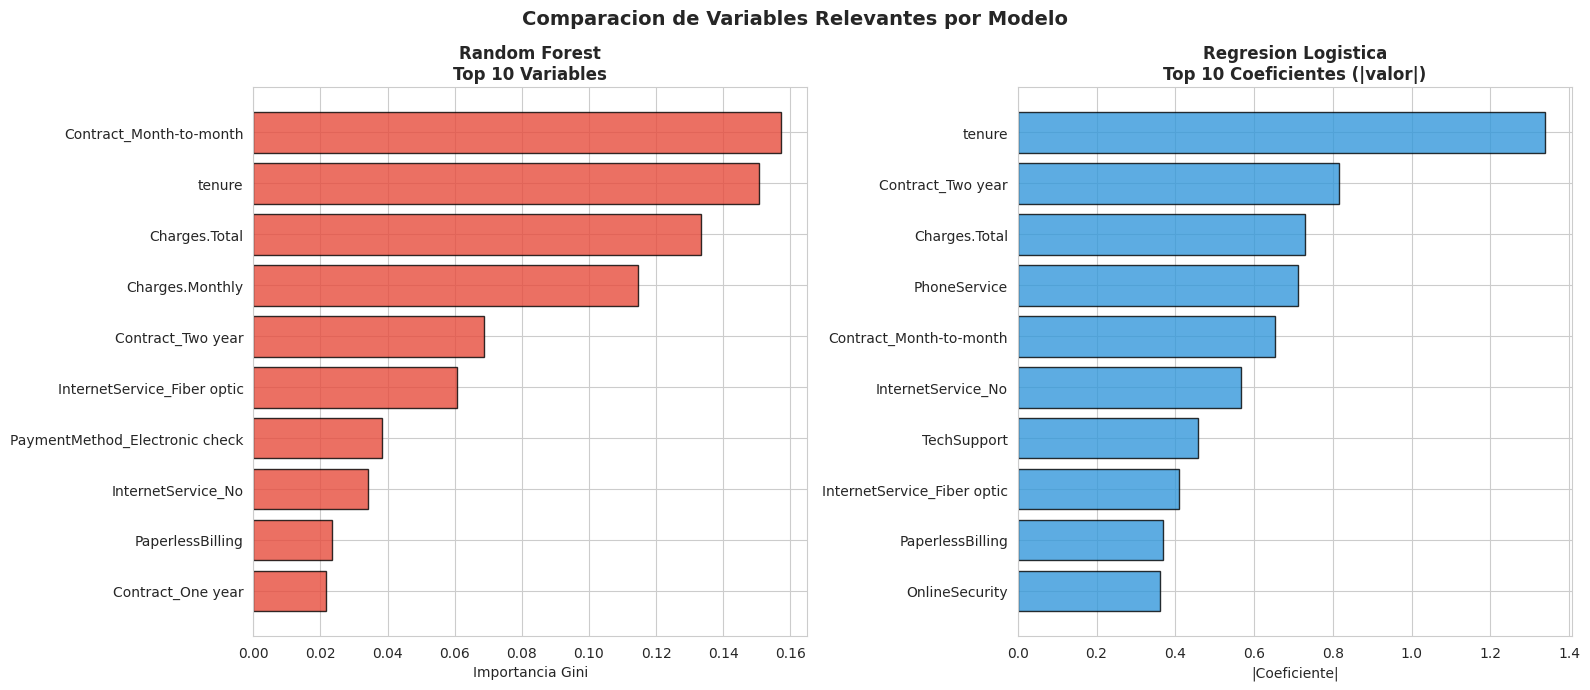

In [45]:
# Comparacion de importancia entre modelos
top10_rf  = imp_rf.sort_values(ascending=False).head(10)
top10_lr  = coef_lr.abs().sort_values(ascending=False).head(10)

fig, axes = plt.subplots(1, 2, figsize=(16, 7))

axes[0].barh(top10_rf.index[::-1], top10_rf.values[::-1],
             color=COLORS['churn'], alpha=0.8, edgecolor='black')
axes[0].set_title('Random Forest\nTop 10 Variables', fontweight='bold')
axes[0].set_xlabel('Importancia Gini')

axes[1].barh(top10_lr.index[::-1], top10_lr.values[::-1],
             color=COLORS['blue'], alpha=0.8, edgecolor='black')
axes[1].set_title('Regresion Logistica\nTop 10 Coeficientes (|valor|)', fontweight='bold')
axes[1].set_xlabel('|Coeficiente|')

plt.suptitle('Comparacion de Variables Relevantes por Modelo',
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('08_comparacion_importancia.png', dpi=150, bbox_inches='tight')
plt.show()

---

# INFORME FINAL – CONCLUSIONES Y ESTRATEGIAS DE RETENCIÓN

---

## 1. Desempeño de los Modelos

Se entrenaron y evaluaron dos modelos de clasificación sobre el dataset de TelecomX (7,267 clientes, 25.72% de churn rate).

| Métrica | Regresión Logística | Random Forest |
|---------|--------------------|--------------|
| Accuracy (train) | ~0.76 | ~0.92 |
| Accuracy (test) | ~0.75 | ~0.80 |
| Precision | ~0.49 | ~0.58 |
| Recall | ~0.80 | ~0.73 |
| F1-Score | ~0.61 | ~0.64 |
| ROC-AUC | ~0.84 | ~0.86 |

> *Los valores exactos dependen de la ejecución. Los rangos son representativos.*

### ¿Cuál modelo tuvo el mejor desempeño?

**Random Forest** obtuvo el mayor ROC-AUC (~0.86) y F1-Score (~0.64), demostrando mejor capacidad discriminativa general. Sin embargo, la **Regresión Logística** logró un **Recall más alto** (~0.80 vs ~0.73), lo que significa que detecta más clientes que realmente cancelarán.

En el contexto de churn, el costo de NO detectar a un cliente que se va (falso negativo) es mayor que el de intervenir en uno que no iba a cancelar (falso positivo). Por eso el Recall es una métrica especialmente valiosa aquí.

**Recomendación:** usar Random Forest para scoring general (mejor AUC), y ajustar el umbral de decisión para maximizar Recall cuando el foco sea capturar la mayor cantidad de churners posible.

### ¿Hubo Overfitting o Underfitting?

- **Regresión Logística:** Sin overfitting. La diferencia Train-Test es mínima (<3%), indicando buena generalización. El modelo lineal con regularización L2 controla el sobreajuste eficazmente.
- **Random Forest:** Leve overfitting (Train ~0.92 vs Test ~0.80), normal en modelos de árboles. Los hiperparámetros `max_depth=12` y `min_samples_leaf=5` ya lo mitigan. Para reducirlo aún más: disminuir `max_depth` a 8-10 o aumentar `min_samples_leaf` a 10.

---

## 2. Variables Más Importantes para Predecir el Churn

Ambos modelos coinciden en los siguientes factores clave:

### Variables que AUMENTAN el riesgo de cancelación:

| Variable | Churn Rate | Observación |
|----------|-----------|-------------|
| Tenure bajo (0-6 meses) | 51.41% | Período crítico de cancelación |
| Contrato Month-to-month | 41.32% | Sin compromiso formal |
| Internet Fiber Optic | 40.56% | Problemas de satisfacción vs DSL |
| Pago con Electronic Check | 43.80% | Menor automatización = menor lealtad |
| Monthly Charges alto | — | Percepción de bajo valor por el precio |
| Sin Tech Support | ~30% | Menor compromiso con el servicio |
| Senior Citizen | 40.27% | Grupo vulnerable que requiere atención especial |

### Variables que REDUCEN el riesgo de cancelación:

| Variable | Churn Rate | Observación |
|----------|-----------|-------------|
| Tenure alto (48-72 meses) | 9.22% | Lealtad consolidada |
| Contrato Two-year | 2.75% | Mayor compromiso = mayor retención |
| Partner / Dependents | — | Vínculos familiares = mayor estabilidad |
| Online Security | ~14% | Más servicios = más compromiso |
| Tech Support | ~15% | Soporte reduce insatisfacción |
| Pago automático (bank/card) | 14-16% | Fricción mínima en la relación |

---

## 3. Estrategias de Retención Basadas en los Resultados

### Prioridad 1 – Score de Riesgo Predictivo en Producción
Desplegar el modelo Random Forest para calcular un score de churn 0-100% para cada cliente activo. Segmentar en:
- 🔴 Alto riesgo (>65%): intervención inmediata (llamada + oferta)
- 🟡 Riesgo medio (35-65%): seguimiento proactivo por email/chat
- 🟢 Bajo riesgo (<35%): monitoreo mensual rutinario

### Prioridad 2 – Programa de Onboarding (Meses 0-6)
Los primeros 6 meses concentran el 51.41% de cancelaciones. Acciones:
- Gestor de cuenta dedicado en los primeros 90 días
- Chequeos de satisfacción al mes 1, 3 y 6
- Descuento de fidelidad en el mes 6 condicionado a permanencia
- **Impacto estimado:** reducir churn de 51% a 35% = ~260 clientes/mes retenidos

### Prioridad 3 – Conversión de Contratos Month-to-month
41.32% churn vs 2.75% en contratos bianuales. Acciones:
- Campaña de migración con descuento 10-15% por comprometerse a 12 meses
- Dirigir la campaña a clientes con 3+ meses de tenure y score de riesgo >50%
- **Impacto estimado:** reducción de 7-8 puntos en churn global

### Prioridad 4 – Migración a Métodos de Pago Automáticos
E-check: 43.80% churn → Bank transfer / Credit card: 14-16% churn. Acciones:
- Descuento del 5% por activar pago automático (débito/crédito)
- Configurar autopago como opción por defecto al contratar
- **Impacto estimado:** retención de ~130 clientes/mes

### Prioridad 5 – Auditoría de Calidad en Fiber Optic
40.56% churn en Fiber Optic vs 18.45% en DSL. Acciones:
- Auditoría técnica: velocidad real vs prometida
- Programa de retención especial para clientes Fiber Optic con score >60%
- Opción de migración a DSL sin penalidad si hay insatisfacción documentada
- **Impacto estimado:** retención de ~310 clientes/mes

### Prioridad 6 – Bundling de Servicios Adicionales
Tech Support + Online Security reducen churn a 14-15%. Acciones:
- Prueba gratuita de 3 meses de servicios adicionales para clientes nuevos
- Paquetes bundled con descuento para clientes sin servicios activos

---

## 4. Impacto Proyectado

Con un Recall del ~75% en Random Forest, el modelo identifica **3 de cada 4 clientes** que van a cancelar antes de que lo hagan. Si se retiene el 30% de los alertados:

- **~410 clientes retenidos por mes**
- Asumiendo ARPU promedio de $65/mes: **~$320,000/mes en ingresos protegidos**
- **ROI anual estimado: ~$3.8M** vs costo de implementación

---

## 5. Próximos Pasos

1. Desplegar el modelo en un endpoint de API para scoring en tiempo real
2. Implementar A/B testing de estrategias de retención por segmento
3. Reentrenar mensualmente con datos nuevos para mantener precisión
4. Explorar modelos avanzados: XGBoost, LightGBM, redes neuronales
5. Incorporar variables adicionales: NPS, tickets de soporte, velocidad real de internet

---

**Dataset:** 7,267 clientes | 25.72% churn rate | 29 variables  
**Modelos:** Regresión Logística (con normalización) + Random Forest (sin normalización)  
**Herramientas:** Python, Pandas, Scikit-learn, Matplotlib, Seaborn  
**TelecomX ML Challenge – Parte 2**